In [1]:
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from collections import Counter

pd.set_option('display.max_columns', None)
%matplotlib inline

In [2]:
df3 = pd.read_csv('data/preprocessed_data.csv')
df3 = df3.drop(df3.columns[0], axis=1)
df3.head()

,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,metformin-rosiglitazone,metformin-pioglitazone,change,readmitted,service_utilization,num_diabetes_meds,change|num_medications,time_in_hospital|num_medications,num_medications|num_procedures,num_lab_procedures|time_in_hospital,num_medications|num_lab_procedures,num_medications|number_diagnoses,age|number_diagnoses,number_diagnoses|time_in_hospital,race_?,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,admission_type_1,admission_type_2,admission_type_3,admission_type_4,admission_type_5,admission_type_6,admission_type_7,admission_type_8,disch_dispo_1,disch_dispo_2,disch_dispo_3,disch_dispo_4,disch_dispo_5,disch_dispo_6,disch_dispo_7,disch_dispo_8,disch_dispo_9,disch_dispo_10,disch_dispo_12,disch_dispo_13,disch_dispo_14,disch_dispo_15,disch_dispo_16,disch_dispo_17,disch_dispo_18,disch_dispo_19,disch_dispo_20,disch_dispo_22,disch_dispo_23,disch_dispo_24,disch_dispo_25,disch_dispo_27,disch_dispo_28,admission_source_1,admission_source_2,admission_source_3,admission_source_4,admission_source_5,admission_source_6,admission_source_7,admission_source_8,admission_source_9,admission_source_10,admission_source_11,admission_source_13,admission_source_14,admission_source_17,admission_source_20,admission_source_22,admission_source_25,level1_diag_0.0,level1_diag_1.0,level1_diag_2.0,level1_diag_3.0,level1_diag_4.0,level1_diag_5.0,level1_diag_6.0,level1_diag_7.0,level1_diag_8.0,max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1C_>7,A1C_>8,A1C_None,A1C_Norm
0,0,5,1,41,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,41,41,1,5,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
1,0,15,3,59,0,18,0,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,1,18,54,0,177,1062,162,135,27,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,0,25,2,11,5,13,2,0,1,6,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,0,26,65,22,143,78,150,12,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,1,35,2,44,1,16,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,1,16,32,16,88,704,112,245,14,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,1,45,1,51,0,8,0,0,0,5,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,2,8,8,0,51,408,40,225,5,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0


In [3]:
# generate feature set and identify target variable
X = df3.loc[:, df3.columns != 'readmitted']
y = df3['readmitted']

#### Logistic Regression

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# using L1 as the penalty term - Lasso Regression will shrink less important features
# Lasso is useful in this scenario becuase we have lot of features in our model

logreg = LogisticRegression(penalty='l1')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [5]:
print("Cross Validation Score: ", cross_val_score(logreg, X_train, y_train, cv=10))
print("Accuracy: ", accuracy_score(y_test, y_pred))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework

Cross Validation Score:  [0.91056581 0.90975461 0.90995741 0.90995741 0.91076861 0.90995741
 0.91056581 0.90975461 0.91016021 0.91135903]
Accuracy:  0.9104717740027445


In [6]:
print("Confusion Matrix:")
pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name = 'Predict'), margins = True)

Confusion Matrix:


Predict,0,1,All
Actual,,,
0,5683,4,5687
1,605,0,605
All,6288,4,6292


In [7]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     19246
           1       0.39      0.00      0.01      1887

   micro avg       0.91      0.91      0.91     21133
   macro avg       0.65      0.50      0.48     21133
weighted avg       0.86      0.91      0.87     21133



In [8]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("AUC: ", auc_score)

Accuracy:  0.9104717740027445
Precision:  0.391304347826087
Recall:  0.0047694753577106515
AUC:  <function auc at 0x1233367b8>


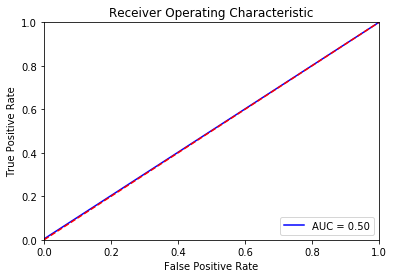

In [9]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [10]:
print('Original dataset shape {}'.format(Counter(y)))
smt = SMOTE(random_state=42)
X_new, y_new = smt.fit_sample(X, y)
print('New dataset shape {}'.format(Counter(y_new)))

Original dataset shape Counter({0: 64146, 1: 6296})
New dataset shape Counter({0: 64146, 1: 64146})


In [11]:
X_new = pd.DataFrame(X_new, columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.3, random_state=42)

logreg = LogisticRegression(penalty='l1')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [12]:
print("Cross Validation Score: ", cross_val_score(logreg, X_train, y_train, cv=10))
print("Accuracy: ", accuracy_score(y_test, y_pred))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework

Cross Validation Score:  [0.94633114 0.94566307 0.94388153 0.94287941 0.9462198  0.94944321
 0.94432071 0.94175947 0.94688196 0.94420314]
Accuracy:  0.9471783413011848


In [13]:
print("Confusion Matrix:")
pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name = 'Predict'), margins = True)

Confusion Matrix:


Predict,0,1,All
Actual,,,
0,19265,22,19287
1,2011,17190,19201
All,21276,17212,38488


In [14]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     19287
           1       1.00      0.90      0.94     19201

   micro avg       0.95      0.95      0.95     38488
   macro avg       0.95      0.95      0.95     38488
weighted avg       0.95      0.95      0.95     38488



In [15]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("AUC: ", auc_score)

Accuracy:  0.9471783413011848
Precision:  0.9987218219846619
Recall:  0.8952658715691891
AUC:  <function auc at 0x1233367b8>


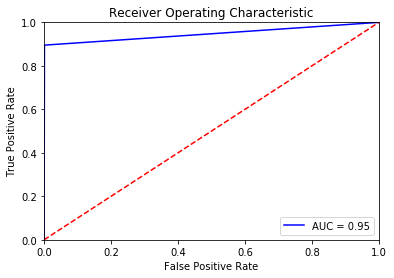

In [16]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Random Forest Classification

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = RandomForestClassifier(n_estimators = 10, max_depth=25, criterion = 'gini', min_samples_split=10)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [18]:
print("Cross Validation Score: ", cross_val_score(clf, X_train, y_train, cv=10))
print("Accuracy: ", accuracy_score(y_test, y_pred))

Cross Validation Score:  [0.91016021 0.90995741 0.90995741 0.90975461 0.90975461 0.91016021
 0.90995741 0.91036301 0.90975461 0.91014199]
Accuracy:  0.910045899777599


In [19]:
print("Confusion Matrix:")
pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name = 'Predict'), margins = True)

Confusion Matrix:


Predict,0,1,All
Actual,,,
0,5675,12,5687
1,604,1,605
All,6279,13,6292


In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     19246
           1       0.21      0.00      0.01      1887

   micro avg       0.91      0.91      0.91     21133
   macro avg       0.56      0.50      0.48     21133
weighted avg       0.85      0.91      0.87     21133



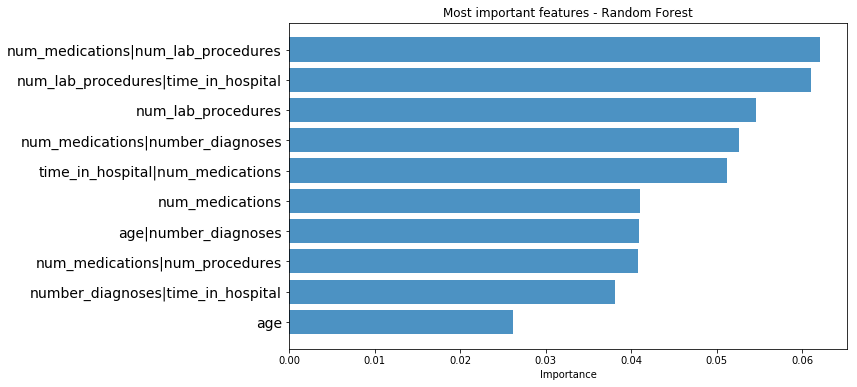

In [21]:
# Create list of most important features
feature_names = X_train.columns
feature_imports = clf.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Random Forest (Original)')
plt.show()

In [22]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("AUC: ", auc_score)

Accuracy:  0.910045899777599
Precision:  0.20833333333333334
Recall:  0.002649708532061473
AUC:  <function auc at 0x1233367b8>


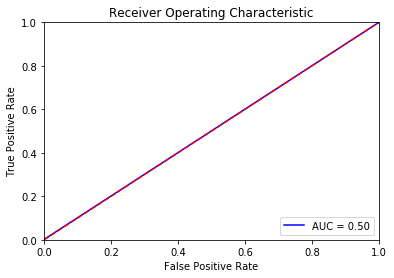

In [23]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [24]:
print('Original dataset shape {}'.format(Counter(y)))
smt = SMOTE(random_state=42)
X_new, y_new = smt.fit_sample(X, y)
print('New dataset shape {}'.format(Counter(y_new)))

Original dataset shape Counter({0: 64146, 1: 6296})
New dataset shape Counter({0: 64146, 1: 64146})


In [25]:
X_new = pd.DataFrame(X_new, columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.3, random_state=42)

clf = RandomForestClassifier(n_estimators = 10, max_depth=25, criterion = 'gini', min_samples_split=10)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [26]:
print("Cross Validation Score: ", cross_val_score(clf, X_train, y_train, cv=10))
print("Accuracy: ", accuracy_score(y_test, y_pred))

Cross Validation Score:  [0.94098653 0.9404298  0.9373121  0.93920499 0.9418773  0.94387528
 0.93942094 0.93518931 0.93730512 0.93963693]
Accuracy:  0.9417740594471004


In [27]:
print("Confusion Matrix:")
pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name = 'Predict'), margins = True)

Confusion Matrix:


Predict,0,1,All
Actual,,,
0,19130,157,19287
1,2084,17117,19201
All,21214,17274,38488


In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94     19287
           1       0.99      0.89      0.94     19201

   micro avg       0.94      0.94      0.94     38488
   macro avg       0.95      0.94      0.94     38488
weighted avg       0.95      0.94      0.94     38488



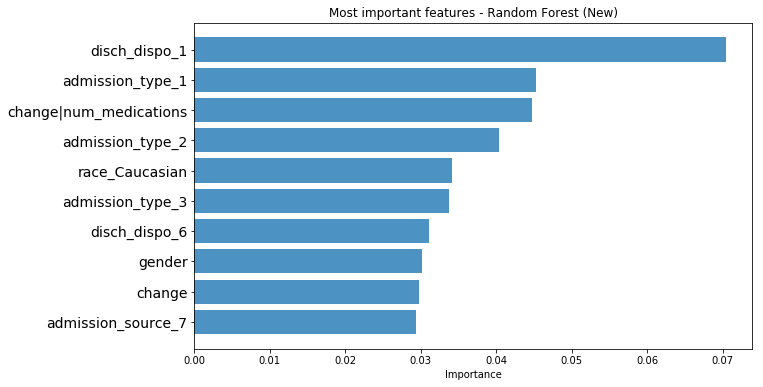

In [29]:
# Create list of most important features
feature_names = X_train.columns
feature_imports = clf.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Random Forest (New)')
plt.show()

In [30]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("AUC: ", auc_score)

Accuracy:  0.9417740594471004
Precision:  0.9909111960171356
Recall:  0.8914639862507161
AUC:  <function auc at 0x1233367b8>


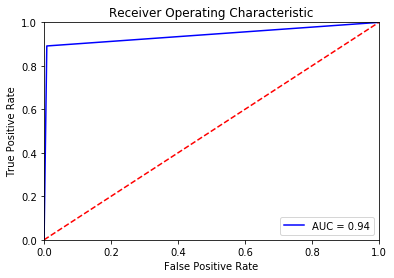

In [31]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()